<a href="https://colab.research.google.com/github/io8ex/2021-assignment-numpy/blob/main/%22GnnExplainer_test%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation of the needed packages

In [1]:
import torch
torch.version.cuda

'11.1'

In [2]:
print(torch.__version__)

1.10.0+cu111


In [3]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 6.9 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 10.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.5 MB 8.4 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 750 kB 8.1 MB/s 
     |████████████████████████████████| 407 kB 8.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=c83f627bbfc9fa7414c578c9aeab9fb0ced8f9e9cf89ac6f604ed72cf9b5807c
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


## Loading packages and the model

In [4]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os
from tqdm import tqdm, trange
import torch.nn as nn
import matplotlib.pyplot as plt

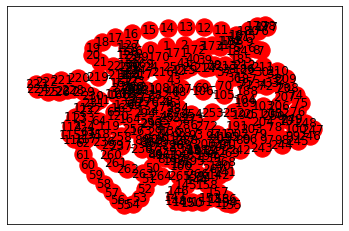

In [5]:
# create dataset 
import networkx as nx
import numpy as np

G = nx.Graph()
nb_nodes = 300
nb_features = 10
nb_dim = 16
nodes = [i for i in range(nb_nodes)]
nodes_t = [list(np.random.randn(nb_features)) for node in nodes]
edges = [[i % nb_nodes, (i + 1) % nb_nodes] for i in range(nb_nodes)]
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw_networkx(G, node_color='r')

# get adjacency

# get edges

In [6]:
# import torch
# from torch_geometric.data import Data

# edge_index = torch.tensor([[0, 1],
#                            [1, 0],
#                            [1, 2],
#                            [2, 1]], dtype=torch.long)
# x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

# data = Data(x=x, edge_index=edge_index.t().contiguous())

In [7]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor(edges, dtype=torch.long)
x = torch.tensor(nodes_t, dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())
data.x.shape, data.edge_index.shape

(torch.Size([300, 10]), torch.Size([2, 300]))

In [8]:
# # #Load the dataset
# dataset = 'cora'
# path = os.path.join(os.getcwd(), 'data', 'Planetoid')
# train_dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())

# # #from torch_geometric.datasets import Twitch
# # # Dataset source: https://github.com/benedekrozemberczki/datasets#twitch-social-networks
# # #train_dataset = Twitch(root=".", name="EN")

# # # Since the dataset is comprised of a single huge graph, we extract that graph by indexing 0.
# data = train_dataset[0]

# Since there is only 1 graph, the train/test split is done by masking regions of the graph. We split the last 500+500 nodes as val and test, and use the rest as the training data.
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:data.num_nodes // 2] = 1
data.val_mask = None
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[data.num_nodes // 2:] = 1

In [9]:
data.x.shape

torch.Size([300, 10])

## Create Neural Network for explanation

In [10]:
class Net(torch.nn.Module):
    def __init__(self, num_features, dim=16, num_classes=1):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, dim)
        self.conv2 = GCNConv(dim, dim)
        self.dense = nn.Linear(dim, num_classes)

    def forward(self, x, edge_index, data=None):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [11]:
epochs = 500
num_features = 10
num_classes = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=nb_dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

In [12]:
def test(model, data):
    model.eval()
    logits, accs = model(data.x, data.edge_index, data), []
    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [13]:
log_logits[data.train_mask], data.y

NameError: ignored

In [ ]:
loss = 999.0
train_acc = 0.0
test_acc = 0.0

t = trange(epochs, desc="Stats: ", position=0)

for epoch in t:

    model.train()
    
    loss = 0

    data = data.to(device)
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index, data)

    # Since the data is a single huge graph, training on the training set is done by masking the nodes that are not in the training set.
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # validate
    train_acc, test_acc = test(model, data)
    train_loss = loss
    
    t.set_description('[Train_loss:{:.6f} Train_acc: {:.4f}, Test_acc: {:.4f}]'.format(loss, train_acc, test_acc))

### Use experiments from Github

In [40]:
!git clone https://github.com/RexYing/gnn-model-explainer

Cloning into 'gnn-model-explainer'...
remote: Enumerating objects: 902, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 902 (delta 8), reused 11 (delta 2), pack-reused 880
Receiving objects: 100% (902/902), 308.94 KiB | 4.17 MiB/s, done.
Resolving deltas: 100% (561/561), done.


In [41]:
import os

dir_model = 'gnn-model-explainer'
os.chdir(dir_model)

In [42]:
!pip install tensorboardX

In [53]:
import warnings

os.chdir('/content/gnn-model-explainer')

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("User", UserWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    !python train.py --dataset=syn2

Using CPU
Method: base
train.py:297: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), args.clip)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch:  0 ; loss:  2.089625597000122 ; train_acc:  0.10714285714285714 ; test_acc:  0.10714285714285714 ; train_prec:  0.04020172361724116 ; test_prec:  0.030350978135788263 ; epoch time:  0.06
train.py:29

In [54]:
os.chdir('/content/gnn-model-explainer')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    !python explainer_main.py --dataset=syn2

Выходные данные были обрезаны до нескольких последних строк (5000).
       grad_fn=<SoftmaxBackward0>)
epoch:  92 ; loss:  2.3811049461364746 ; mask density:  0.022243231534957886 ; pred:  tensor([0.0290, 0.8184, 0.0846, 0.0057, 0.0050, 0.0416, 0.0141, 0.0016],
       grad_fn=<SoftmaxBackward0>)
epoch:  93 ; loss:  2.3505613803863525 ; mask density:  0.022035494446754456 ; pred:  tensor([0.0290, 0.8186, 0.0847, 0.0057, 0.0050, 0.0415, 0.0140, 0.0016],
       grad_fn=<SoftmaxBackward0>)
epoch:  94 ; loss:  2.3208465576171875 ; mask density:  0.021833639591932297 ; pred:  tensor([0.0290, 0.8187, 0.0847, 0.0057, 0.0050, 0.0414, 0.0140, 0.0016],
       grad_fn=<SoftmaxBackward0>)
epoch:  95 ; loss:  2.2919070720672607 ; mask density:  0.021637560799717903 ; pred:  tensor([0.0290, 0.8189, 0.0848, 0.0057, 0.0050, 0.0412, 0.0139, 0.0016],
       grad_fn=<SoftmaxBackward0>)
epoch:  96 ; loss:  2.2637197971343994 ; mask density:  0.021446984261274338 ; pred:  tensor([0.0289, 0.8190, 0.0848, 0.0

[(0, 1), (1, 2), (1, 3), (3, 5), (3, 6), (3, 7), (4, 7), (7, 8), (7, 9)] [0.9987682104110718, 0.9983554482460022, 0.9975160360336304, 0.9970535039901733, 0.9958109259605408, 0.9978829622268677, 0.9983197450637817, 0.9982632398605347, 0.9982450008392334]


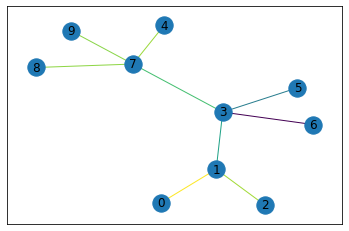

In [37]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def visulaize_prediction(idx, threshold = .4, exp=5):
    # get saved mask
    os.chdir(os.path.join('/content/gnn-model-explainer', 'log'))
    file_name = f"masked_adj_syn{exp}_base_h20_o20_explainnode_idx_{idx}graph_idx_-1.npy"
    with open(file_name, 'rb') as f:
        mask = np.load(f)

    # visualize mask
    mask_thr = mask > threshold
    G = nx.from_numpy_matrix(mask_thr)
    st = set()
    for tup in G.edges:
      st.add(tup[0])
      st.add(tup[1])
    len_G = len(G.nodes)
    nodes_remove = [node for node in range(len_G) if node not in st]
    G.remove_nodes_from(nodes_remove)
    colors = []
    for tup in list(G.edges):
        colors.append(mask[tup[0], tup[1]])
    print(G.edges, colors)
  
    f = nx.draw_networkx(G, edge_color=colors)
    try:
        os.mkdir('figs')
    except: 
        pass
    plt.savefig(f'figs/prediction_{idx}.jpg')                     

i = 14
visulaize_prediction(400 + 5*i, .01)

## Explain the network

In [ ]:
data.edge_index

In [ ]:
node_idx = 8
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model, epochs=200,)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

In [ ]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

In [ ]:
train_dataset[0].node_stores